In [1]:
import numpy as np # linear algebra
from keras.preprocessing.text import text_to_word_sequence


Using TensorFlow backend.


In [2]:
# load preprocessed word dictionary.
wordsList = np.load('wordIndex_all.npy')
wordsList = wordsList.tolist() #Originally loaded as numpy array

# load data file to be classified
data_path = "/home/wangjin/Download_Data/"

fname = data_path + "incidents_sentiment.idx"

fname2 = data_path + "incidents_sentiment2.idx"

In [3]:
# Reverse from integers to words using the DICTIONARY
reverse_word_index = dict(
[(value, key) for (key, value) in wordsList.items()])

# parse doc id and messages from idx file
def parseDocs(fname,maxNumRecords=-1):
    
    # loop all records in the data file
    data = []
    n=-1
    text = []

    with open(fname, "r", encoding='utf-8') as f:
        for line in f:
            try:
                if not line.isspace(): 
                    field = line.split()
                    if field[0] == '#DREREFERENCE':
                        if (n >= 0 and maxNumRecords == -1) or (n >= 0 and n < maxNumRecords and maxNumRecords > 0): 
                            data[n].append('. '.join(text))
                            text = []
                        n += 1
                        if n == maxNumRecords and maxNumRecords > 0:
                             break
                        else:
                            data.append([])
                            data[n].append(field[1])
                    if field[0].find("#DRE") < 0:
                        text.append(line.rstrip())  #append all lines without newline \n              
            except:
                print(n,line)
        
        # append last line
        if maxNumRecords < 0:
            data[n].append('. '.join(text))
                
    print(len(data))
    return data

# converting words to ids based on pre-trained word dictionary
def encodeDocs(docList,maxSeqLength,wordDict):
    ids = np.zeros((len(docList), maxSeqLength), dtype='int32')
    
    for i in range(len(docList)):
        try:
            # split text to words
            words = text_to_word_sequence(docList[i][1], filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ')

            for indexCounter,word in enumerate(words):
                if indexCounter == maxSeqLength:
                    break
                try:  
                    ids[i][indexCounter] = wordsList[word]
                except KeyError:
                    ids[i][indexCounter] = 1 #ID for unkown words "UNK"
        except:
            print(i,docList[i])
            
        #if (i + 1) % 100 == 0:
            #print(i+1)

    return ids

In [4]:
# define some parameters
maxNunRecords = 200 # Maximum number of docs for debugging. -1 means all reords

# parse data to from idx files 
data1 = parseDocs(fname2,-1)
data2 = parseDocs(fname2,-1)

22223
22223


In [6]:
# encoding docs 
maxSeqLength = 250 # Maximum number of words for each document

ids1 = encodeDocs(data1,maxSeqLength,wordsList)
#np.save("idsMatrix_pos", ids_p)
ids2 = encodeDocs(data2,maxSeqLength,wordsList)

In [7]:
# load pretrained model
from keras.models import load_model

# returns a compiled model
# identical to the previous one
model = load_model('weights-improvement-86-0.83.hdf5')

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 50)           2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 2,029,570
Trainable params: 2,029,570
Non-trainable params: 0
_________________________________________________________________


In [8]:
# predict sentiment scores for input text
predictedSentiment1 = model.predict(ids1)
predictedSentiment2 = model.predict(ids2)

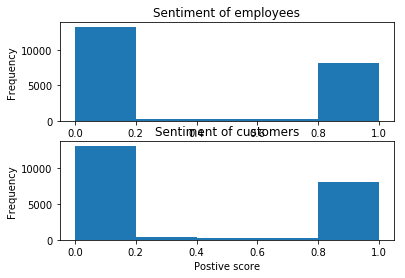

In [9]:
# plot score distributions
import matplotlib.pyplot as plt
%matplotlib inline

plt.subplot(211)
plt.hist(predictedSentiment1[:,0], 5)
plt.xlabel('Postive score')
plt.ylabel('Frequency')
plt.title('Sentiment of employees')

plt.subplot(212)
plt.hist(predictedSentiment2[:,0], 5)
plt.xlabel('Postive score')
plt.ylabel('Frequency')
plt.title('Sentiment of customers')

plt.show()